In [1]:
!nvidia-smi

Wed Dec  2 11:19:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     |████████████████████████████████| 245kB 10.9MB/s 
     |████████████████████████████████| 317kB 17.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81698 sha256=b652f7f8ab862dfcc50ddcc3390c0e521cc1b3fcf13bbcde5f4e510b11a31a6e
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [4]:
dataset = pd.read_csv(r'movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

In [7]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [8]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:08<00:00, 1845.15it/s]

CPU times: user 26.8 s, sys: 298 ms, total: 27.1 s
Wall time: 27 s


## Preprocessing


In [9]:
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [10]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175859), ('<PAD>', 0), 1)

In [11]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [12]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175860
Number of Documents=35000


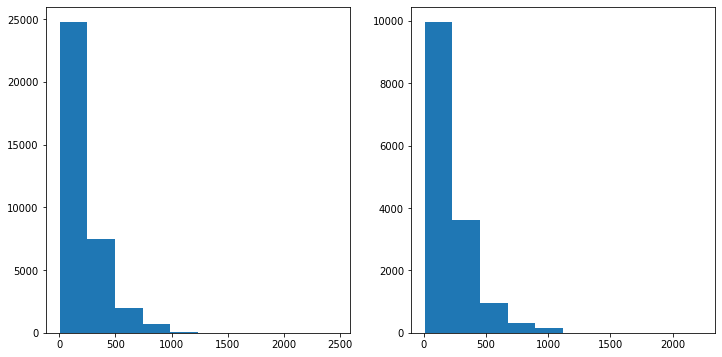

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [14]:
MAX_SEQUENCE_LENGTH = 1000

In [15]:
# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [17]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [18]:
VOCAB_SIZE = len(t.word_index)

# LSTM Model




# LSTM



In [19]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         52758000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 300)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 53,010,929
Trainable params: 53,010,929
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [20]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 191s 774ms/step - loss: 0.4040 - accuracy: 0.8125 - val_loss: 0.3099 - val_accuracy: 0.8691
Epoch 2/10
247/247 [==============================] - 190s 768ms/step - loss: 0.1592 - accuracy: 0.9410 - val_loss: 0.3466 - val_accuracy: 0.8603
Epoch 3/10
247/247 [==============================] - 191s 772ms/step - loss: 0.0959 - accuracy: 0.9663 - val_loss: 0.5586 - val_accuracy: 0.8674
Epoch 00003: early stopping


## Evaluate Model Performance

In [21]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 30s 64ms/step - loss: 0.3081 - accuracy: 0.8697
Accuracy: 86.97%


In [22]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [23]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      7490
    positive       0.86      0.88      0.87      7510

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



,negative,positive
negative,6440,1050
positive,904,6606


# Stacked LSTM Model

## Build Model Architecture

In [25]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model2.add(tf.keras.layers.SpatialDropout1D(0.1))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 300)         52758000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 128)         219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 53,142,513
Trainable params: 53,142,513
Non-trainable params: 0
__________________________________________

## Train Model

In [26]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
           callbacks=[es],
           shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 231s 937ms/step - loss: 0.3973 - accuracy: 0.8196 - val_loss: 0.3065 - val_accuracy: 0.8734
Epoch 2/10
247/247 [==============================] - 241s 975ms/step - loss: 0.1534 - accuracy: 0.9458 - val_loss: 0.3633 - val_accuracy: 0.8769
Epoch 3/10
247/247 [==============================] - 240s 972ms/step - loss: 0.0538 - accuracy: 0.9824 - val_loss: 0.4723 - val_accuracy: 0.8809
Epoch 00003: early stopping


## Evaluate Model Performance

In [27]:
# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 52s 111ms/step - loss: 0.3006 - accuracy: 0.8769
Accuracy: 87.69%


In [28]:
predictions = model2.predict_classes(X_test).ravel()
predictions[:10]

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [29]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [30]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.92      0.82      0.87      7490
    positive       0.84      0.93      0.88      7510

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



,negative,positive
negative,6165,1325
positive,522,6988
